In [ ]:
# 导入相关库
import numpy as np
import akshare as ak
import pandas as pd
import pytz
import rqdatac
import datetime as dt
import matplotlib.pyplot as plt
import os

start_date = 20150101
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y%m%d")

rqdatac.init()

T_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="T",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)

TF_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="TF",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)



# 中国宏观杠杆率
"""名称	类型	描述
年份	object	日期, 年-月
居民部门	float64	-
非金融企业部门	float64	-
政府部门	float64	-
中央政府	float64	-
地方政府	float64	-
实体经济部门	float64	-
金融部门资产方	float64	-
金融部门负债方	float64	-
"""
macro_cnbs_df = ak.macro_cnbs()
macro_cnbs_df.columns = [
    "Year",
    "Household Sector",
    "Non-Financial Corporate Sector",
    "Government Sector",
    "Central Government",
    "Local Government",
    "Real Economy Sector",
    "Financial Sector Assets",
    "Financial Sector Liabilities",
]
macro_cnbs_df["Year"] = pd.to_datetime(macro_cnbs_df["Year"])
# 国民经济运行状况
"""名称	类型	描述
月份	object	-
总指数-指数值	float64	-
总指数-同比增长	float64	注意单位: %
总指数-环比增长	float64	注意单位: %
农产品-指数值	float64	-
农产品-同比增长	float64	注意单位: %
农产品-环比增长	float64	注意单位: %
矿产品-指数值	float64	-
矿产品-同比增长	float64	注意单位: %
矿产品-环比增长	float64	注意单位: %
煤油电-指数值	float64	-
煤油电-同比增长	float64	注意单位: %
煤油电-环比增长	float64	注意单位: %"""
macro_china_qyspjg_df = ak.macro_china_qyspjg()
macro_china_qyspjg_df.columns = [
    "Month",
    "Total Index Value",
    "Total Index YoY Growth",
    "Total Index MoM Growth",
    "Agricultural Products Index Value",
    "Agricultural Products YoY Growth",
    "Agricultural Products MoM Growth",
    "Mineral Products Index Value",
    "Mineral Products YoY Growth",
    "Mineral Products MoM Growth",
    "Coal Oil Electricity Index Value",
    "Coal Oil Electricity YoY Growth",
    "Coal Oil Electricity MoM Growth",
]

# 外商直接投资
"""名称	类型	描述
月份	object	-
当月	int64	-
当月-同比增长	float64	注意单位: 美元
当月-环比增长	float64	注意单位: %
累计	float64	注意单位: 美元
累计-同比增长	float64	注意单位: %"""
macro_china_fdi_df = ak.macro_china_fdi()
macro_china_fdi_df.columns = ["Month", "Current Month", "Current Month YoY Growth", "Current Month MoM Growth", "Cumulative", "Cumulative YoY Growth"]

# LPR品种数据
"""名称	类型	描述
TRADE_DATE	object	日期
LPR1Y	float64	LPR_1Y利率(%)
LPR5Y	float64	LPR_5Y利率(%)
RATE_1	float64	短期贷款利率:6个月至1年(含)(%)
RATE_2	float64	中长期贷款利率:5年以上(%)"""
macro_china_lpr_df = ak.macro_china_lpr()
macro_china_lpr_df.columns = [
    "Trade Date",
    "LPR 1Y Rate",
    "LPR 5Y Rate",
    "Short-term Loan Rate (6 months to 1 year)",
    "Medium and Long-term Loan Rate (over 5 years)",
]
macro_china_lpr_df["Trade Date"] = pd.to_datetime(macro_china_lpr_df["Trade Date"])

# 城镇调查失业率
"""名称	类型	描述
date	object	年月
item	object	-
value	float64	-
"""
macro_china_urban_unemployment_df = ak.macro_china_urban_unemployment()
macro_china_urban_unemployment_df.columns = ["Date", "Item", "Value"]
macro_china_urban_unemployment_df["Date"] = pd.to_datetime(macro_china_urban_unemployment_df["Date"], format="%Y%m")

# 社会融资规模增量统计
"""名称	类型	描述
月份	object	年月
社会融资规模增量	float64	注意单位: 亿元
其中-人民币贷款	float64	注意单位: 亿元
其中-委托贷款外币贷款	float64	注意单位: 折合人民币, 亿元
其中-委托贷款	float64	注意单位: 亿元
其中-信托贷款	float64	注意单位: 亿元
其中-未贴现银行承兑汇票	float64	注意单位: 亿元
其中-企业债券	float64	注意单位: 亿元
其中-非金融企业境内股票融资	float64	注意单位: 亿元"""
macro_china_shrzgm_df = ak.macro_china_shrzgm()
macro_china_shrzgm_df.columns = [
    "Date",
    "Total Social Financing Increment",
    "RMB Loans",
    "Entrusted Loans in Foreign Currency",
    "Entrusted Loans",
    "Trust Loans",
    "Undiscounted Bank Acceptance Bills",
    "Corporate Bonds",
    "Domestic Stock Financing of Non-Financial Enterprises",
]
macro_china_shrzgm_df["Date"] = pd.to_datetime(macro_china_shrzgm_df["Date"], format="%Y%m")

# 中国 GDP 年率
"""名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: %
预测值	float64	注意单位: %
前值	float64	注意单位: %"""
macro_china_gdp_yearly_df = ak.macro_china_gdp_yearly()
macro_china_gdp_yearly_df.columns = ["Item", "Date", "Current Value", "Forecast Value", "Previous Value"]
macro_china_gdp_yearly_df["Date"] = pd.to_datetime(macro_china_gdp_yearly_df["Date"])

# 物价水平
"""名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: %
预测值	float64	注意单位: %
前值	float64	注意单位: %
"""
macro_china_cpi_yearly_df = ak.macro_china_cpi_yearly()
macro_china_cpi_yearly_df.columns = ["Item", "Date", "Current Value", "Forecast Value", "Previous Value"]
macro_china_cpi_yearly_df["Date"] = pd.to_datetime(macro_china_cpi_yearly_df["Date"])

# 中国 CPI 月率报告
"""名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: %
预测值	float64	注意单位: %
前值	float64	注意单位: %"""
macro_china_cpi_monthly_df = ak.macro_china_cpi_monthly()
macro_china_cpi_monthly_df.columns = ["Item", "Date", "Current Value", "Forecast Value", "Previous Value"]
macro_china_cpi_monthly_df["Date"] = pd.to_datetime(macro_china_cpi_monthly_df["Date"])

# 中国 PPI 年率报告
"""名称	类型	描述
月份	object	-
当月	float64	-
当月同比增长	float64	注意单位: %
累计	float64	-"""
macro_china_ppi_df = ak.macro_china_ppi()
macro_china_ppi_df.columns = ["Date", "Current Month", "Current Month MoM Growth", "Previous Value"]
macro_china_ppi_df["Date"] = pd.to_datetime(macro_china_ppi_df["Date"])

C:\Users\yanzh\AppData\Local\Programs\Python\Python313\Lib\site-packages\rqdatac\client.py:257: UserWarning: Your account will be expired after  7 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


  0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
# 将相关数据提取并合并为单一 DataFrame
macro_data = pd.DataFrame()

# 提取 CPI 年率数据
macro_cpi = macro_china_cpi_yearly_df[["Date", "Current Value"]]
macro_cpi.columns = ["Date", "CPI Yearly"]

# 提取 GDP 年率数据
macro_gdp = macro_china_gdp_yearly_df[["Date", "Current Value"]]
macro_gdp.columns = ["Date", "GDP Yearly"]

# 提取 LPR 数据
macro_lpr = macro_china_lpr_df[["Trade Date", "LPR 1Y Rate", "LPR 5Y Rate"]]
macro_lpr.columns = ["Date", "LPR 1Y Rate", "LPR 5Y Rate"]

# 提取社会融资规模增量数据
macro_shrzgm = macro_china_shrzgm_df[["Date", "Total Social Financing Increment"]]
macro_shrzgm.columns = ["Date", "Total Social Financing Increment"]

# 合并所有数据
macro_data = (
    pd.merge(macro_cpi, macro_gdp, on="Date", how="outer")
    .merge(macro_lpr, on="Date", how="outer")
    .merge(macro_shrzgm, on="Date", how="outer")
)

# 排序日期并填充缺失值
macro_data = macro_data.sort_values(by="Date").reset_index(drop=True)
macro_data.fillna(method="ffill", inplace=True)

# 显示合并后的结果
macro_data.head()
"""
        Date  CPI Yearly  GDP Yearly  LPR 1Y Rate  LPR 5Y Rate  \
0 1986-02-01         7.1         NaN          NaN          NaN   
1 1986-03-01         7.1         NaN          NaN          NaN   
2 1986-04-01         7.1         NaN          NaN          NaN   
3 1986-05-01         7.1         NaN          NaN          NaN   
4 1986-06-01         7.1         NaN          NaN          NaN   

Total Social Financing Increment  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
    """


'\n        Date  CPI Yearly  GDP Yearly  LPR 1Y Rate  LPR 5Y Rate  0 1986-02-01         7.1         NaN          NaN          NaN   \n1 1986-03-01         7.1         NaN          NaN          NaN   \n2 1986-04-01         7.1         NaN          NaN          NaN   \n3 1986-05-01         7.1         NaN          NaN          NaN   \n4 1986-06-01         7.1         NaN          NaN          NaN   \n\nTotal Social Financing Increment  \n0                               NaN  \n1                               NaN  \n2                               NaN  \n3                               NaN  \n4                               NaN  \n    '

In [ ]:
# Combine the TF_df and macro_data
# Resample macro_data to daily frequency and forward fill the values
macro_data_daily = macro_data.set_index("Date").resample("D").ffill().reset_index()

# Merge TF_df with macro_data_daily
T_prices = (T_df["open"] + T_df["close"]) / 2
TF_prices = (TF_df["open"] + TF_df["close"]) / 2
spread_df = pd.DataFrame(
    {
        "TF_prices": TF_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
    }
)

# spread_df.columns = ["TF_prices", "T_prices"] and index is date in datetime format
spread_df_combined = spread_df.reset_index().merge(macro_data_daily, left_on="date", right_on="Date", how="left").set_index(["Date"])

# Display the combined DataFrame
print(spread_df_combined.columns)
# 'dominant_id', 'open', 'close', 'high', 'low', 'total_turnover',
# 'volume', 'prev_close', 'settlement', 'prev_settlement',
# 'open_interest', 'limit_up', 'limit_down', 'day_session_open', 'Date',
# 'CPI Yearly', 'GDP Yearly', 'LPR 1Y Rate', 'LPR 5Y Rate',
# 'Total Social Financing Increment'

Index(['date', 'TF_prices', 'T_prices', 'CPI Yearly', 'GDP Yearly',
       'LPR 1Y Rate', 'LPR 5Y Rate', 'Total Social Financing Increment'],
      dtype='object')


In [4]:
spread_df_combined["T-TF"] = spread_df_combined["T_prices"] - spread_df_combined["TF_prices"]

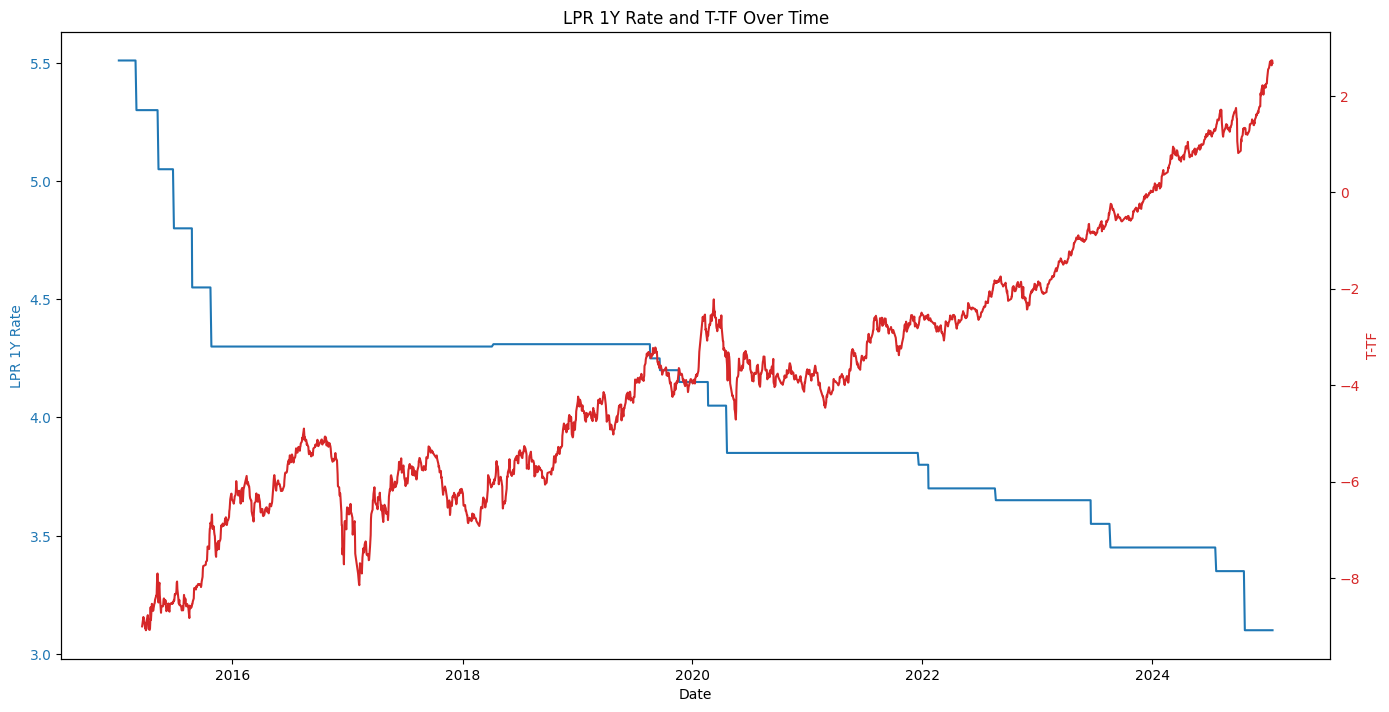

In [12]:
import seaborn as sns

# Calculate the correlation matrix
correlation = spread_df_combined[['T-TF', 'LPR 1Y Rate', 'Total Social Financing Increment']].corr()

# Plot the LPR 1Y Rate and T-TF against date
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('LPR 1Y Rate', color='tab:blue')
ax1.plot(spread_df_combined.index, spread_df_combined['LPR 1Y Rate'], color='tab:blue', label='LPR 1Y Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('T-TF', color='tab:red')
ax2.plot(spread_df_combined.index, spread_df_combined['T-TF'], color='tab:red', label='T-TF')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('LPR 1Y Rate and T-TF Over Time')
plt.show()

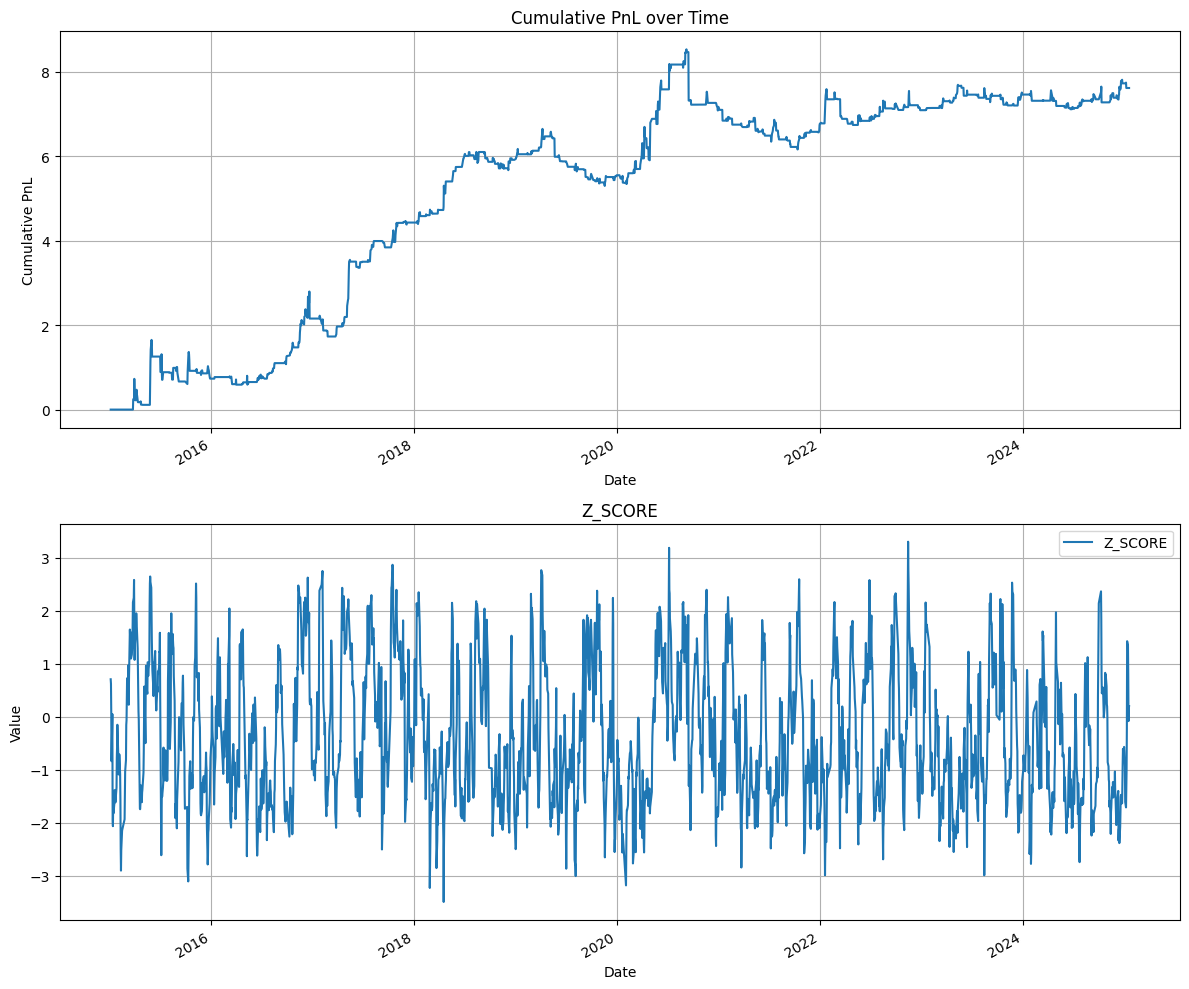

In [6]:
# Combine the TF_df and macro_data
# Resample macro_data to daily frequency and forward fill the values
macro_data_daily = macro_data.set_index("Date").resample("D").ffill().reset_index()

# Merge TF_df with macro_data_daily
TF_df_combined = TF_df.reset_index().merge(macro_data_daily, left_on="date", right_on="Date", how="left").set_index(["underlying_symbol", "date"])

# Display the combined DataFrame
TF_df_combined.columns

# 策略调整
entry_threshold = 1.5
exit_threshold = 1
look_back_window = 20

T_prices = (T_df["open"] + T_df["close"]) / 2
TF_prices = (TF_df["open"] + TF_df["close"]) / 2

# 基点价值计算（久期近似值）
T_BPV = 7.5 / 100 * 1_000_000
TF_BPV = 4.5 / 100 * 1_000_000
BPV_ratio = T_BPV / TF_BPV

spread_df = pd.DataFrame(
    {
        "TF_prices": TF_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": BPV_ratio,
        "entry_threshold": entry_threshold,
        "exit_threshold": exit_threshold,
        "look_back_window": look_back_window,
    }
)

# 计算价差
spread_df["T-2TF"] = TF_prices.droplevel(level=0) - 2 * TF_prices.droplevel(level=0) / BPV_ratio

# 计算移动均值和标准差
spread_df["MEAN"] = spread_df["T-2TF"].rolling(window=look_back_window, min_periods=1).mean()
spread_df["SD"] = spread_df["T-2TF"].rolling(window=look_back_window, min_periods=1).std()
spread_df["Z_SCORE"] = (spread_df["T-2TF"] - spread_df["MEAN"]) / spread_df["SD"]

# 初始化持仓状态
spread_df["POSITION_T"] = 0
spread_df["POSITION_TF"] = 0
# 记录每日持仓和盈亏
spread_df["PNL"] = 0
spread_df["CUM_PNL"] = 0

for i in range(len(spread_df)):
    if spread_df.iloc[i]["Z_SCORE"] < -entry_threshold:
        # 价差过大，卖出T，买入两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += -1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += 2
    elif spread_df.iloc[i]["Z_SCORE"] > entry_threshold:
        # 价差过小，买入T，卖出两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += 1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += -2
    elif abs(spread_df.iloc[i]["Z_SCORE"]) <= exit_threshold:
        # 价差回归，平仓
        spread_df.at[spread_df.index[i], "POSITION_T"] = 0
        spread_df.at[spread_df.index[i], "POSITION_TF"] = 0

    # 计算当日盈亏
    if i > 0:
        position_T = spread_df.iloc[i - 1]["POSITION_T"]
        position_TF = spread_df.iloc[i - 1]["POSITION_TF"]
        daily_pnl = position_T * (spread_df.iloc[i]["T_prices"] - spread_df.iloc[i - 1]["T_prices"]) + position_TF * (
            spread_df.iloc[i]["TF_prices"] - spread_df.iloc[i - 1]["TF_prices"]
        )
        spread_df.at[spread_df.index[i], "PNL"] = daily_pnl
        spread_df.at[spread_df.index[i], "CUM_PNL"] = spread_df.iloc[: i + 1]["PNL"].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Cumulative PnL
spread_df["CUM_PNL"].plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL")
ax1.set_title("Cumulative PnL over Time")
ax1.grid(True)

# Plot Z_SCORE
spread_df["Z_SCORE"].plot(ax=ax2, label="Z_SCORE")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.set_title("Z_SCORE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# Create directory if it doesn't exist
os.makedirs(os.path.join(".", "plot"), exist_ok=True)
plt.savefig(os.path.join(".", "plot", "T_2TF.png"))
plt.show()

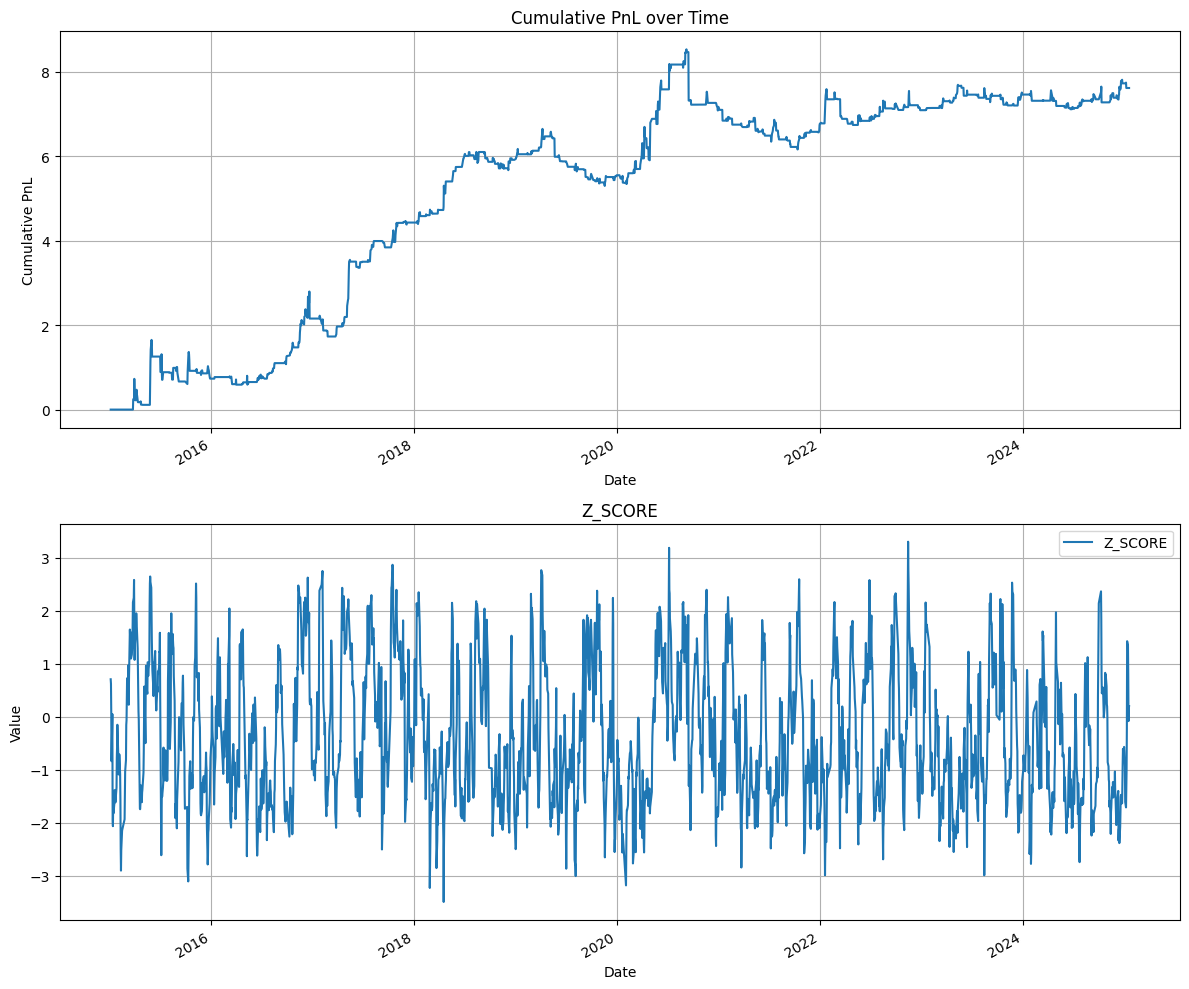

In [7]:
# 策略调整
entry_threshold = 1.5
exit_threshold = 1
look_back_window = 20

T_prices = (T_df["open"] + T_df["close"]) / 2
TF_prices = (TF_df["open"] + TF_df["close"]) / 2

# 基点价值计算（久期近似值）
T_BPV = 7.5 / 100 * 1_000_000
TF_BPV = 4.5 / 100 * 1_000_000
BPV_ratio = T_BPV / TF_BPV

spread_df = pd.DataFrame(
    {
        "TF_prices": TF_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": BPV_ratio,
        "entry_threshold": entry_threshold,
        "exit_threshold": exit_threshold,
        "look_back_window": look_back_window,
    }
)

# 计算价差
spread_df["T-2TF"] = TF_prices.droplevel(level=0) - 2 * TF_prices.droplevel(level=0) / BPV_ratio

# 计算移动均值和标准差
spread_df["MEAN"] = spread_df["T-2TF"].rolling(window=look_back_window, min_periods=1).mean()
spread_df["SD"] = spread_df["T-2TF"].rolling(window=look_back_window, min_periods=1).std()
spread_df["Z_SCORE"] = (spread_df["T-2TF"] - spread_df["MEAN"]) / spread_df["SD"]

# 初始化持仓状态
spread_df["POSITION_T"] = 0
spread_df["POSITION_TF"] = 0
# 记录每日持仓和盈亏
spread_df["PNL"] = 0
spread_df["CUM_PNL"] = 0

for i in range(len(spread_df)):
    if spread_df.iloc[i]["Z_SCORE"] < -entry_threshold:
        # 价差过大，卖出T，买入两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += -1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += 2
    elif spread_df.iloc[i]["Z_SCORE"] > entry_threshold:
        # 价差过小，买入T，卖出两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += 1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += -2
    elif abs(spread_df.iloc[i]["Z_SCORE"]) <= exit_threshold:
        # 价差回归，平仓
        spread_df.at[spread_df.index[i], "POSITION_T"] = 0
        spread_df.at[spread_df.index[i], "POSITION_TF"] = 0

    # 计算当日盈亏
    if i > 0:
        position_T = spread_df.iloc[i - 1]["POSITION_T"]
        position_TF = spread_df.iloc[i - 1]["POSITION_TF"]
        daily_pnl = position_T * (spread_df.iloc[i]["T_prices"] - spread_df.iloc[i - 1]["T_prices"]) + position_TF * (
            spread_df.iloc[i]["TF_prices"] - spread_df.iloc[i - 1]["TF_prices"]
        )
        spread_df.at[spread_df.index[i], "PNL"] = daily_pnl
        spread_df.at[spread_df.index[i], "CUM_PNL"] = spread_df.iloc[: i + 1]["PNL"].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Cumulative PnL
spread_df["CUM_PNL"].plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL")
ax1.set_title("Cumulative PnL over Time")
ax1.grid(True)

# Plot Z_SCORE
spread_df["Z_SCORE"].plot(ax=ax2, label="Z_SCORE")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.set_title("Z_SCORE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# Create directory if it doesn't exist
os.makedirs(os.path.join(".", "plot"), exist_ok=True)
plt.savefig(os.path.join(".", "plot", "T_2TF.png"))
plt.show()

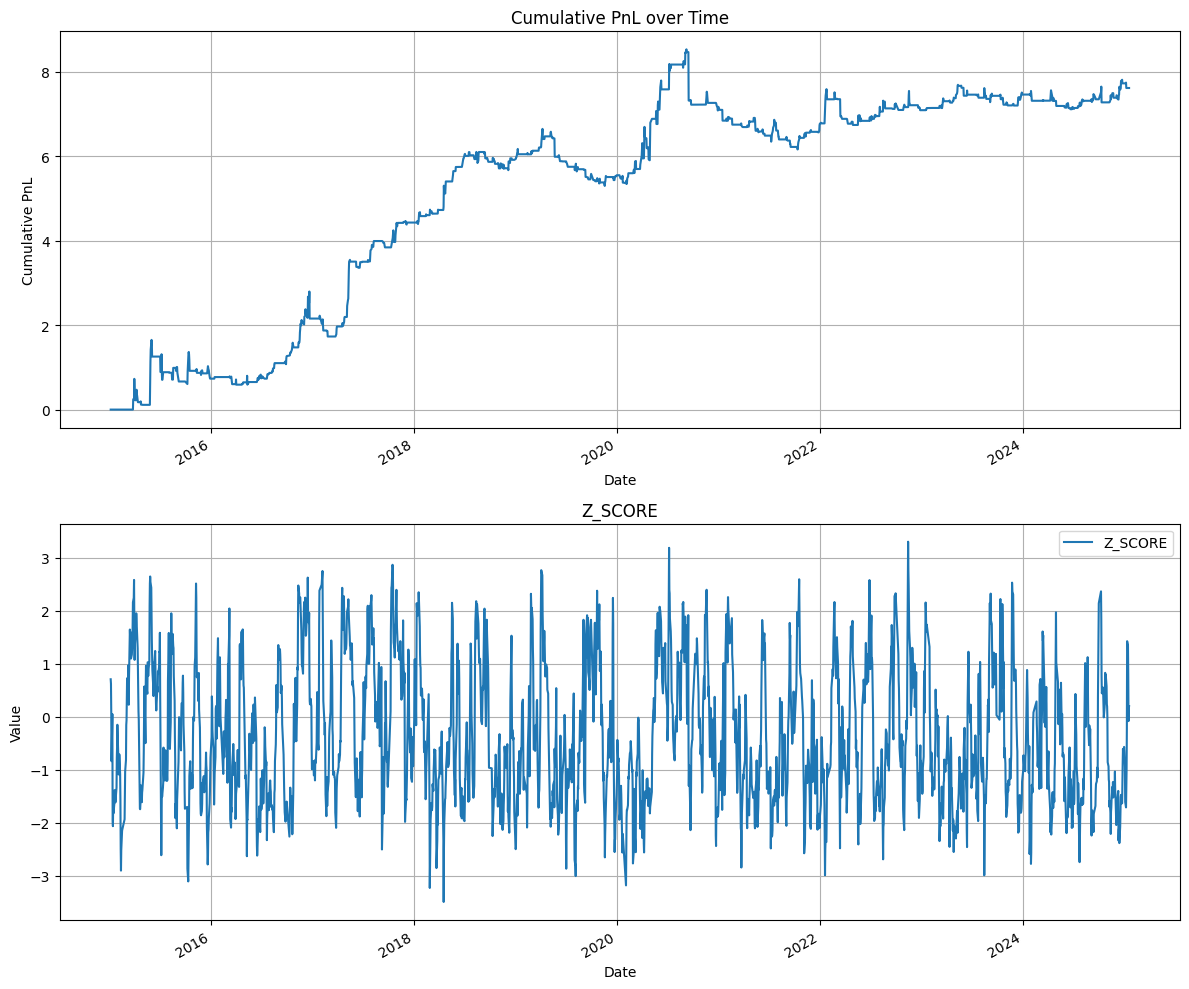

In [8]:
# 策略调整
entry_threshold = 1.5
exit_threshold = 1
look_back_window = 20

T_prices = (T_df["open"] + T_df["close"]) / 2
TF_prices = (TF_df["open"] + TF_df["close"]) / 2

# 基点价值计算（久期近似值）
T_BPV = 7.5 / 100 * 1_000_000
TF_BPV = 4.5 / 100 * 1_000_000
BPV_ratio = T_BPV / TF_BPV

spread_df = pd.DataFrame(
    {
        "TF_prices": TF_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": BPV_ratio,
        "entry_threshold": entry_threshold,
        "exit_threshold": exit_threshold,
        "look_back_window": look_back_window,
    }
)

# 计算价差
spread_df["T-2TF"] = TF_prices.droplevel(level=0) - 2 * TF_prices.droplevel(level=0) / BPV_ratio

# 计算移动均值和标准差
spread_df["MEAN"] = spread_df["T-2TF"].rolling(window=look_back_window, min_periods=1).mean()
spread_df["SD"] = spread_df["T-2TF"].rolling(window=look_back_window, min_periods=1).std()
spread_df["Z_SCORE"] = (spread_df["T-2TF"] - spread_df["MEAN"]) / spread_df["SD"]

# 初始化持仓状态
spread_df["POSITION_T"] = 0
spread_df["POSITION_TF"] = 0
# 记录每日持仓和盈亏
spread_df["PNL"] = 0
spread_df["CUM_PNL"] = 0

for i in range(len(spread_df)):
    if spread_df.iloc[i]["Z_SCORE"] < -entry_threshold:
        # 价差过大，卖出T，买入两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += -1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += 2
    elif spread_df.iloc[i]["Z_SCORE"] > entry_threshold:
        # 价差过小，买入T，卖出两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += 1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += -2
    elif abs(spread_df.iloc[i]["Z_SCORE"]) <= exit_threshold:
        # 价差回归，平仓
        spread_df.at[spread_df.index[i], "POSITION_T"] = 0
        spread_df.at[spread_df.index[i], "POSITION_TF"] = 0

    # 计算当日盈亏
    if i > 0:
        position_T = spread_df.iloc[i - 1]["POSITION_T"]
        position_TF = spread_df.iloc[i - 1]["POSITION_TF"]
        daily_pnl = position_T * (spread_df.iloc[i]["T_prices"] - spread_df.iloc[i - 1]["T_prices"]) + position_TF * (
            spread_df.iloc[i]["TF_prices"] - spread_df.iloc[i - 1]["TF_prices"]
        )
        spread_df.at[spread_df.index[i], "PNL"] = daily_pnl
        spread_df.at[spread_df.index[i], "CUM_PNL"] = spread_df.iloc[: i + 1]["PNL"].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Cumulative PnL
spread_df["CUM_PNL"].plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL")
ax1.set_title("Cumulative PnL over Time")
ax1.grid(True)

# Plot Z_SCORE
spread_df["Z_SCORE"].plot(ax=ax2, label="Z_SCORE")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.set_title("Z_SCORE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# Create directory if it doesn't exist
os.makedirs(os.path.join(".", "plot"), exist_ok=True)
plt.savefig(os.path.join(".", "plot", "T_2TF.png"))
plt.show()

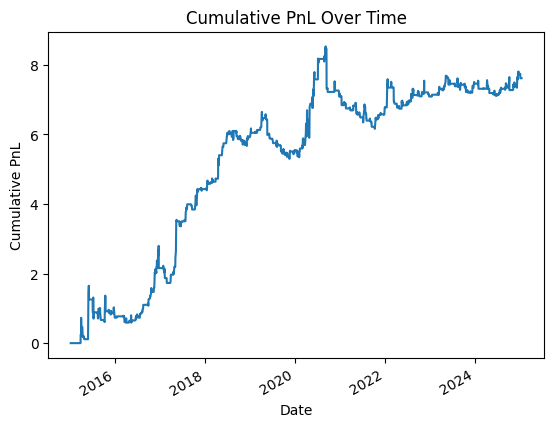

In [9]:
spread_df['CUM_PNL'].plot(title='Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.show()

In [10]:
spread_df

,TF_prices,T_prices,BPV_ratio,entry_threshold,exit_threshold,look_back_window,T-2TF,MEAN,SD,Z_SCORE,POSITION_T,POSITION_TF,PNL,CUM_PNL
date,,,,,,,,,,,,,,
2015-01-05,90.6250,NaN,1.666667,1.5,1,20,-18.1250,-18.125000,NaN,NaN,0,0,0.0,0.0000
2015-01-06,90.4740,NaN,1.666667,1.5,1,20,-18.0948,-18.109900,0.021355,0.707107,0,0,NaN,0.0000
2015-01-07,90.4660,NaN,1.666667,1.5,1,20,-18.0932,-18.104333,0.017916,0.621428,0,0,NaN,0.0000
2015-01-08,90.5140,NaN,1.666667,1.5,1,20,-18.1028,-18.103950,0.014648,0.078508,0,0,NaN,0.0000
2015-01-09,90.5950,NaN,1.666667,1.5,1,20,-18.1190,-18.106960,0.014361,-0.838403,0,0,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,106.3325,109.0650,1.666667,1.5,1,20,-21.2665,-21.310000,0.032312,1.346257,0,0,0.0,7.6125
2025-01-14,106.4175,109.0500,1.666667,1.5,1,20,-21.2835,-21.309625,0.032586,0.801718,0,0,0.0,7.6125
2025-01-15,106.5675,109.2900,1.666667,1.5,1,20,-21.3135,-21.310875,0.032211,-0.081495,0,0,0.0,7.6125
